#  XPCS   GISAXS Pipeline 

 "This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

## NSLS2 data retrieval imports

In [1]:
from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler
from filestore.retrieve import _h_registry, _HANDLER_CACHE, HandlerBase
from eiger_io.pims_reader import EigerImages
from chxtools import handlers

## Import all the required packages for  Data Analysis

#* scikit-beam - data analysis tools for X-ray science 
#    - https://github.com/scikit-beam/scikit-beam
#* xray-vision - plotting helper functions for X-ray science
#    - https://github.com/Nikea/xray-vision

import xray_vision
import xray_vision.mpl_plotting as mpl_plot  
from xray_vision.mpl_plotting import speckle
from xray_vision.mask.manual_mask import ManualMask

import skbeam.core.roi as roi
import skbeam.core.correlation as corr
import skbeam.core.utils as utils

import numpy as np
from datetime import datetime
import h5py

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib notebook
#%matplotlib inline

## Users put
  - uid for Bluesky Scan
  - filename for acquiring data directly by EigerSofteare



In [2]:
BlueScan = True
DirectAcq = False

detector = 'eiger_4M_cam_img_image_lightfield'  #for old eiger images before Jan 30, 2016
#detector = 'eiger4m_image'  #for new eiger images after Jan 30, 2016


### Get the events from the uid

In [3]:
if BlueScan:
    uid = 'ffe9d518'
else:
    uid = '/XF11ID/data/2015/11/23/d01ab510-3cf3-4719-bee3_795_master.h5' 
hdr = db[uid]

In [7]:
if BlueScan:
    hdr = db[uid]
    ev, = get_events(hdr, [detector])
    imgs = ev['data'][detector]
else:    
    imgs =  Images(uid)
print (imgs)
Nimg=len(imgs)

hdf5 path = /XF11ID/data/2015/11/8/3f84f57d-79b7-4a10-8b51_5_master.h5
<Frames>
Length: 15000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint32


## Get data path

In [8]:
if BlueScan:
    from datetime import datetime
    dt = datetime.fromtimestamp(hdr['start'].time)
    path ='/XF11ID/analysis' + '/%s/%s/%s/' % (dt.year, dt.month, dt.day)
    
path

'/XF11ID/analysis/2015/11/8/'

## Getting GISAXS scattering vector

## Note:  experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)

In [9]:
imgs.md

{'beam_center_x': 840.0,
 'beam_center_y': 1830.0,
 'count_time': 1.0,
 'detector_distance': 4.8400002,
 'frame_time': 1.00001,
 'incident_wavelength': 1.3776,
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [10]:
# The physical size of the pixels
dpix = imgs.md['x_pixel_size'] * 1000.  
lambda_ = imgs.md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 4.81        # detector to sample distance (mm)

exposuretime= imgs.md['count_time']
acquisition_period = imgs.md['frame_time']

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

timeperframe, exposuretime

(1.00001, 1.0)

## load a mask if exist 
### otherwise create a mask using Mask pipeline

In [11]:
mask = np.load( path +  str(uid)+ "_mask.npy")

## Reverse the mask in y-direction due to the coordination difference between python and Eiger software

In [12]:
maskr = mask[::-1,:]

## Plot the mask

<IPython.core.display.Javascript object>


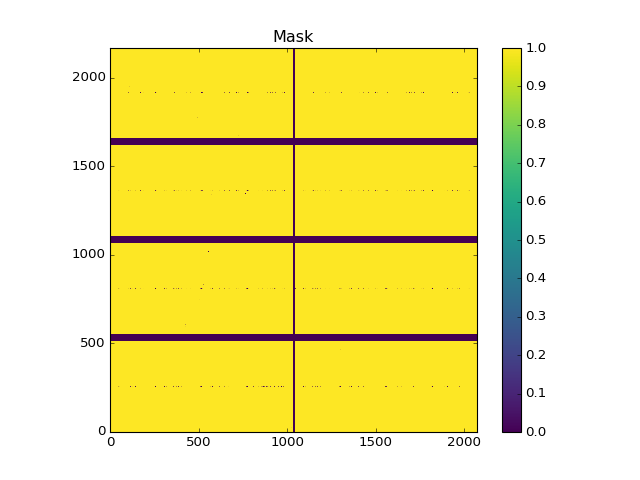

In [13]:
fig, ax = plt.subplots()
im = ax.imshow(maskr, origin='lower', vmin=0, vmax=1, cmap='viridis')
ax.set_title("Mask")
fig.colorbar(im)
plt.show()

##  Get the average image

In [14]:
avg_img = np.average(imgs[::500], axis=0)*mask

### Reverse the image in y-direction due to the coordination difference between python and Eiger software¶

In [15]:
avg_imgr  = avg_img[::-1,:] 

## Plot the averged image with the mask

<IPython.core.display.Javascript object>


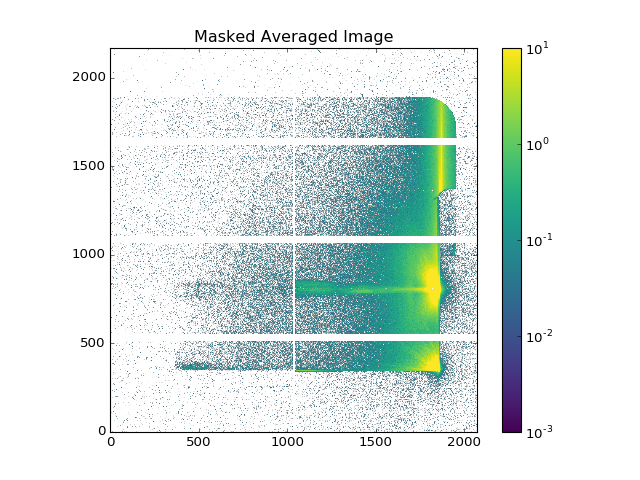

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(avg_imgr, cmap='viridis',origin='lower',
               norm= LogNorm(vmin=0.001, vmax=1e1))
ax.set_title("Masked Averaged Image")
fig.colorbar(im)
plt.show()

## To mask the each image

In [17]:
class Masker(object):
    def __init__(self, indexable, mask):
        self.indexable = indexable
        self.mask = mask
    def __getitem__(self, key):
        return self.indexable[key] * mask

In [66]:
imgsrm = Reverse_Coordinate(imgs, mask)  #the image series are inversed and appllied mask
#masker = Masker(imgsr, maskr)

## GiSAXS get q-map (qz and qr)
## Users put incident-Beam and Reflection_Beam Centers here!!!

In [18]:
inc_x0 = 1871
inc_y0 = 339
refl_x0 = 1871
refl_y0 = 811      #1670
Lsd= 4.81
lamda= lambda_  #12.4/9

In [19]:
cd /XF11ID/analysis/Analysis_Pipelines/Develop/

/XF11ID/analysis/Analysis_Pipelines/Develop


In [22]:
%run develop.py

In [23]:
alphaf,thetaf, alphai, phi = get_reflected_angles( inc_x0, inc_y0,refl_x0 , refl_y0, Lsd=Lsd )
qx, qy, qr, qz = convert_gisaxs_pixel_to_q( inc_x0, inc_y0,refl_x0,refl_y0, lamda=lamda, Lsd=Lsd )


The incident_angle (alphai) is: 0.210835132612
The incident_angle (alphai) is: 0.210835132612


<IPython.core.display.Javascript object>


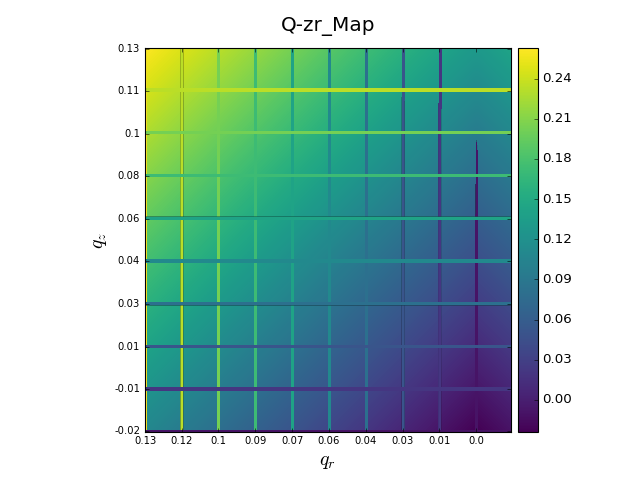

In [27]:
ticks = show_qzr_map(  qr, qz, inc_x0, data = None, Nzline=10, Nrline= 10   )

<IPython.core.display.Javascript object>


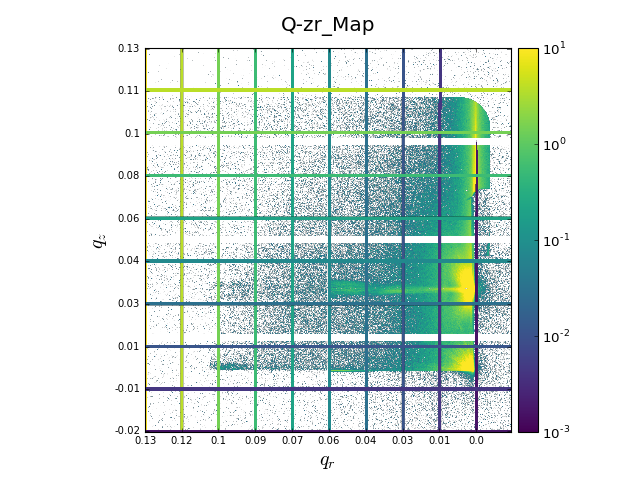

In [29]:
ticks = show_qzr_map(  qr,qz, inc_x0, data = avg_imgr, Nzline=10,  Nrline=10   )

## Get q||-intensity¶
## Users put cuts here!!!

In [30]:
## to make two-qz, from 0.018 to 0.046, width as 0.008, 
qz_width = 0.008
qz_start = 0.018 + qz_width/2
qz_end = 0.046  -  qz_width/2
qz_num= 2

#to make one-qr, from 0.02 to 0.1, and the width is 0.1-0.012
qr_width =  0.1-0.02
qr_start =    0.02 + qr_width  /2
qr_end =  0.01 -  qr_width  /2
qr_num = 1
 
Qr = [qr_start , qr_end, qr_width, qr_num]
Qz=  [qz_start,   qz_end,  qz_width , qz_num ]

In [36]:
new_mask = np.ones_like(avg_imgr, dtype= np.int)
new_mask[ :, 1020:1045] =0

The qr_edge is:  [ 0.02  0.1 ]
The qr_center is:  [ 0.06]
The qz_edge is:  [ 0.018  0.026  0.038  0.046]
The qz_center is:  [ 0.022  0.042]


<IPython.core.display.Javascript object>


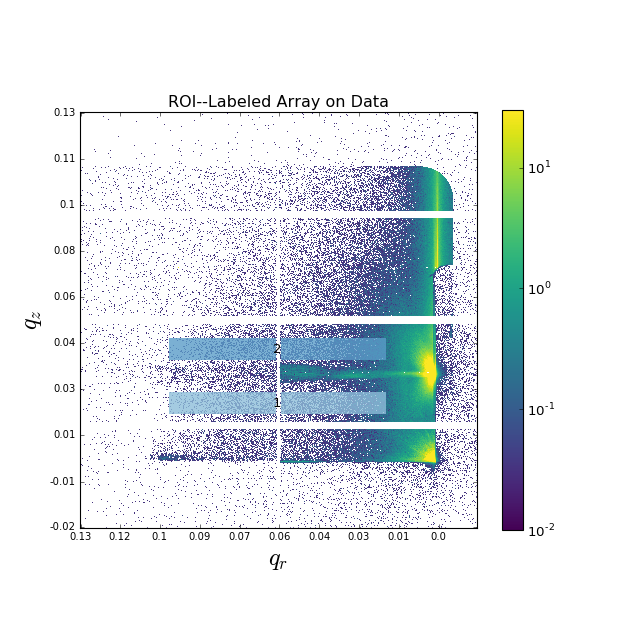

<IPython.core.display.Javascript object>


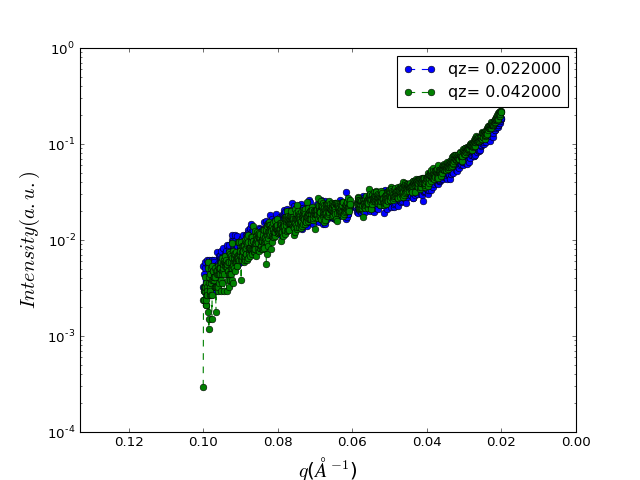

In [39]:
qr_1d = get_1d_qr( avg_imgr, Qr, Qz, qr, qz, inc_x0,  new_mask,  True, ticks, .8)

## User provide the interested Qz and Qr here

In [40]:
qz_start = 0.022
qz_end = 0.042
qz_num = 2
qz_width = 0.008 #(qz_end - qz_start)/(qz_num +1)

qr_start =  0.01
qr_end = 0.09
qr_num = 10
qr_width = (qr_end - qr_start)/qr_num



## Create label array (Qz, Qr, Qzr boxes)

In [43]:
qr_edge, qr_center = get_qedge(qr_start, qr_end, qr_width, qr_num )
qz_edge, qz_center = get_qedge(qz_start, qz_end, qz_width, qz_num )
      
label_array_qz = get_qmap_label(qz, qz_edge)
label_array_qr = get_qmap_label(qr, qr_edge)

label_array_qzr, qzc, qrc = get_qzrmap(label_array_qz, label_array_qr, 
                                       qz_center, qr_center)

labels_qzr, indices_qzr = roi.extract_label_indices(label_array_qzr)
labels_qz, indices_qz = roi.extract_label_indices(label_array_qz)
labels_qr, indices_qr = roi.extract_label_indices(label_array_qr)

num_qz = len(np.unique(labels_qz))
num_qr = len(np.unique(labels_qr))
num_qzr = len(np.unique(labels_qzr))

## Extract the labeled array

In [44]:
boxes = label_array_qzr 
box_maskr = boxes*maskr

qind, pixelist = roi.extract_label_indices(box_maskr)
noqs = len(np.unique(qind))

## Number of pixels in each q ring

In [45]:
nopr = np.bincount(qind, minlength=(noqs+1))[1:]
nopr

array([25088, 12544, 12544, 12544, 12544, 12544, 11760, 12534, 12544,
       12544, 25088, 12544, 12544, 12544, 12544, 12544, 11760, 12544,
       12544, 12544])

## plot average image with interested Q-regions (boxes)

<IPython.core.display.Javascript object>


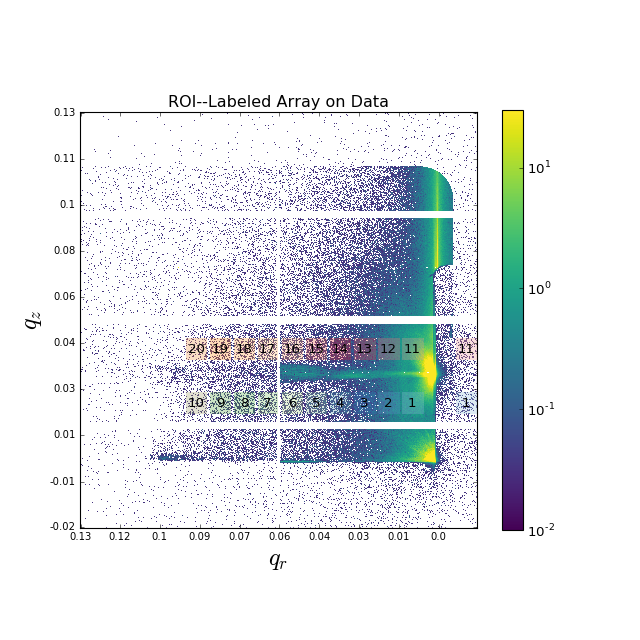

In [46]:
show_qzr_roi( avg_imgr, box_maskr, inc_x0, ticks)

##  Mean intensities for each ring

In [67]:
mask_data = imgsrm[::100]  #this one is too slow if make  masker[::1]
mean_int_sets, index_list = roi.mean_intensity( mask_data, label_array_qzr)

In [72]:
mean_int_sets.shape

(150, 20)

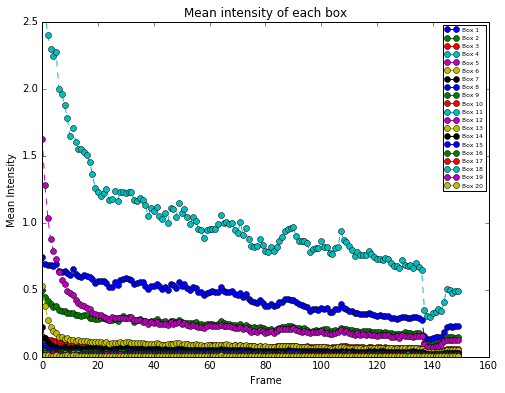

In [75]:
times = np.arange(  mean_int_sets.shape[0]   )  #*timeperframe  # get the time for each frame

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("Mean intensity of each box")
for i in range(  num_qzr  ):
    ax.plot(times, mean_int_sets[:,i], '--o', label="Box "+str(i+1))
    ax.set_xlabel("Frame")
    ax.set_ylabel("Mean Intensity")
    ax.set_ylim(0, 2.5)
    
ax.legend( loc='best', fontsize = 6) 
plt.show()

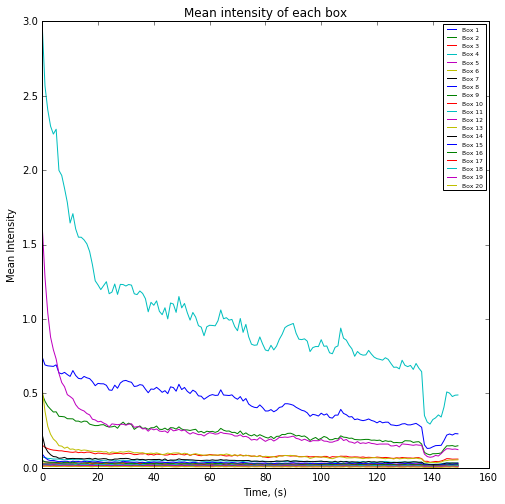

In [77]:
time = np.arange(len(mask_data))*timeperframe  # get the time for each frame

%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Mean intensity of each box")
for i in range( num_qzr):
    ax.plot(time, mean_int_sets[:,i], label="Box "+str(i+1))
    ax.set_xlabel("Time, (s)")
    ax.set_ylabel("Mean Intensity")
ax.legend(loc='best', fontsize=6) 
plt.show()

## One time Correlation

Note : Enter the number of levels and number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/correlation.py

In [78]:
good_start = 4000
good_end = 4100

imgs_ =imgs[good_start: good_end-1]
imgsr = Reverse_Coordinate(imgs_, mask) 


num_lev = 12  # number of levels
num_buf = 8  # number of buffers



g2, lag_steps = corr.multi_tau_auto_corr(num_lev, num_buf, box_maskr, imgsr)

In [80]:
lags = lag_steps * timeperframe

In [82]:
tg2 = np.hstack( [ lags.reshape( len(lags),1), g2] )
#np.save( path + 'g2_%s-%s--%s'%(uid,good_start, good_end), tg2)
np.savetxt( path + 'g2_%s-%s--%s.txt'%(uid,good_start, good_end), tg2)


In [117]:
import itertools 
qzr_vals = [[],[]]
for qzcen in qz_center:
    qzr_vals[0].append( [qzcen]* len(qr_center) )
    qzr_vals[1].append( qr_center )
   
qzr_vals[0] = list(itertools.chain(*qzr_vals[0]))
qzr_vals[1] = list(itertools.chain(*qzr_vals[1]))  
qzr_vals = np.array( qzr_vals )
np.savetxt( path + 'qzr_vals_%s-%s--%s.txt'%(uid,good_start, good_end), qzr_vals)

### Plot the one time correlation functions

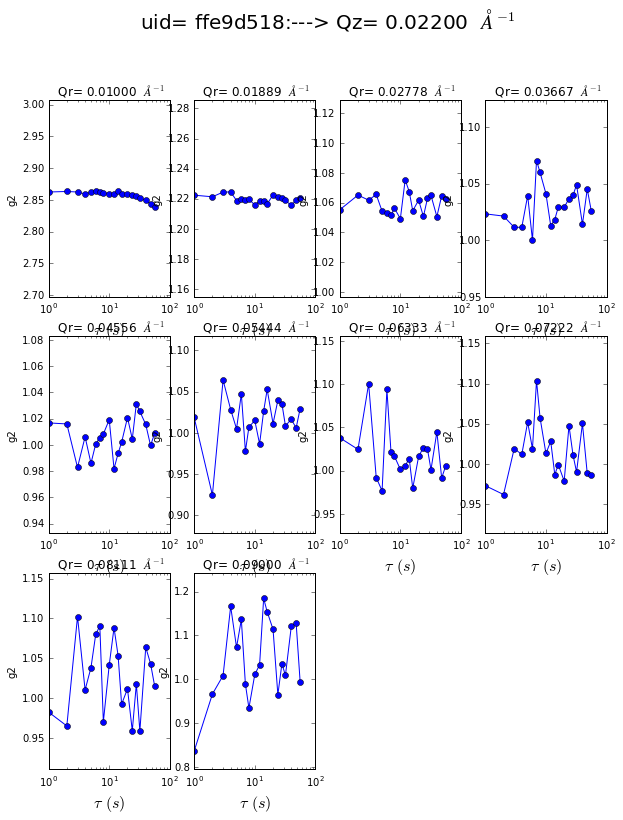

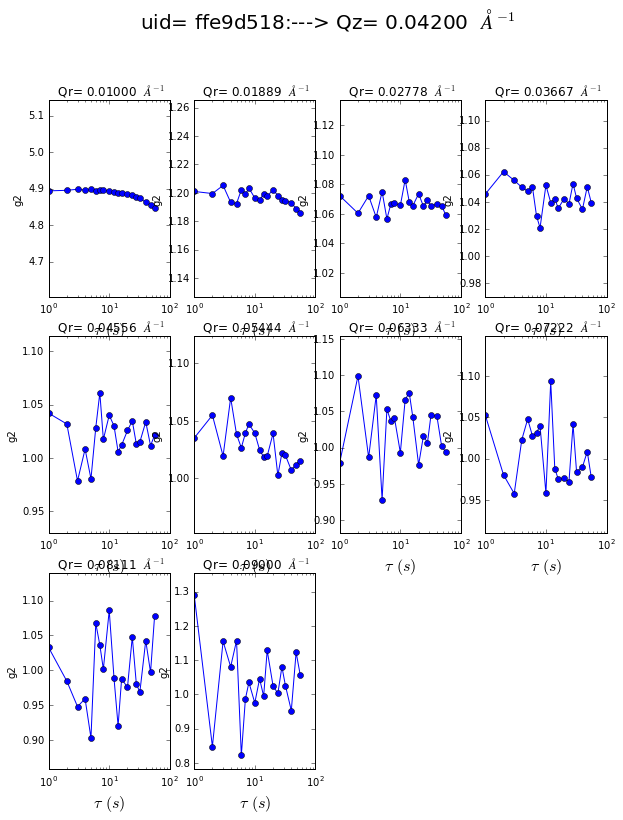

In [81]:
vmin = 1.1
vmax=  1.15

for qz_ind in range(num_qz):
    fig = plt.figure(figsize=(10, 12))
    #fig = plt.figure()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=20, y =1.1) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    for sn in range(num_qr):
        ax = fig.add_subplot(sx,sy,sn+1 )
        ax.set_ylabel("g2") 
        ax.set_xlabel(r"$\tau $ $(s)$", fontsize=16) 
               
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:
            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        ax.set_title( title  )
            
            
        y=g2[:, sn + qz_ind * num_qr]
        ax.semilogx(lags, y, '-o', markersize=6) 
        ax.set_ylim([min(y)*.95, max(y[1:])*1.05 ])
        #ax.set_ylim( vmin, vmax)
        
    plt.show()
    fig.tight_layout()  


# Fit g2

In [119]:
from lmfit import  Model
mod = Model(corr.auto_corr_scat_factor)


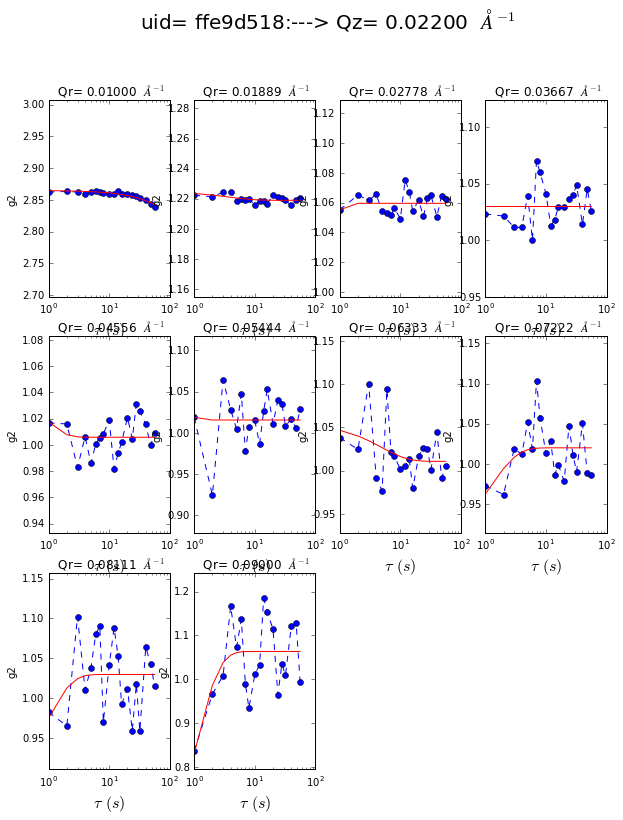

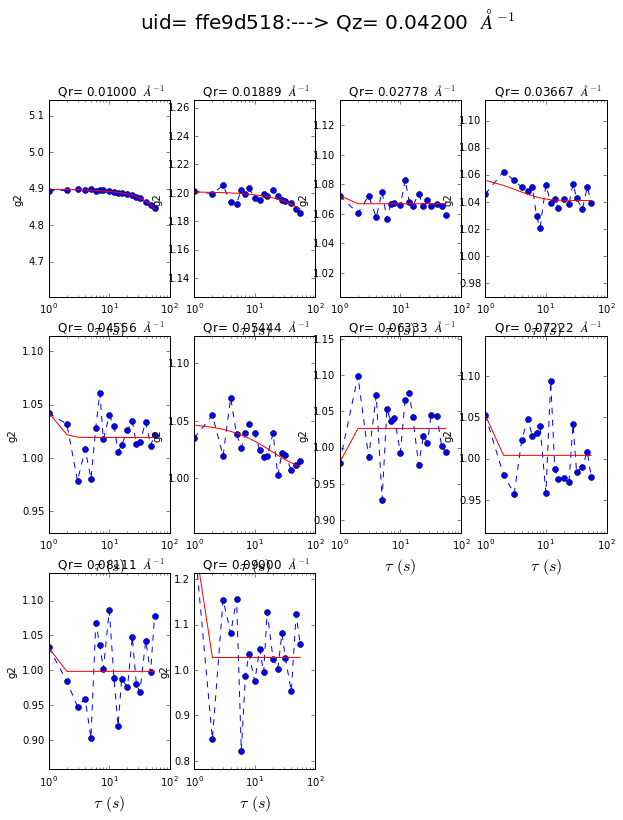

In [121]:
vmin = 1.1
vmax=  1.15

rate = {}

for qz_ind in range(num_qz):
    rate[qz_ind] =[]
    fig = plt.figure(figsize=(10, 12))
    #fig = plt.figure()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=20, y =1.1) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    for sn in range(num_qr):
        
        ax = fig.add_subplot(sx,sy,sn+1 )
        ax.set_ylabel("g2") 
        ax.set_xlabel(r"$\tau $ $(s)$", fontsize=16) 
               
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:
            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        ax.set_title( title  )           
            
        y=g2[1:, sn + qz_ind * num_qr]
        result1 = mod.fit(y, lags=lags[1:], beta=.1,
                      relaxation_rate =.5, baseline=1.0)
        rate[qz_ind].append(result1.best_values['relaxation_rate'])
    
        ax.semilogx(lags[1:], y, '--o', markersize=6) 
        ax.semilogx(lags[1:], result1.best_fit, '-r')
        ax.set_ylim([min(y)*.95, max(y[1:])*1.05 ])
        #ax.set_ylim( vmin, vmax)
        
    plt.show()
    fig.tight_layout()  


In [124]:
result1.best_values

{'baseline': 1.0273635141273887,
 'beta': 39000.524870672511,
 'relaxation_rate': 5.9521772898836094}

## Plot the relaxation rates vs (q_ring_center)**2

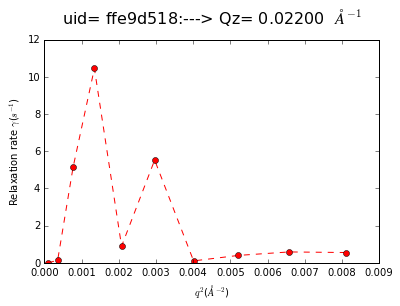

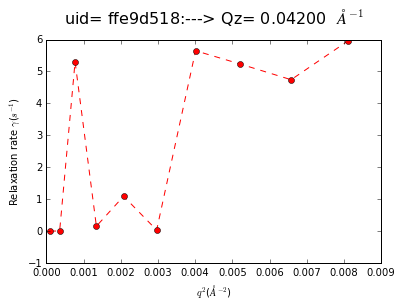

In [126]:
for qz_ind in range(num_qz):     
    #fig = plt.figure(figsize=(10, 12))
    #fig = plt.figure()
    fig, ax=plt.subplots()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
    #print (qz_ind,title_qz)
    #if num_qz!=1:plt.axis('off')
        
    ax.plot(qr_center**2 , rate[qz_ind] , 'ro', ls='--')
    #ax.set_ylim( 0, 0.001)
    ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
    ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
    
    plt.show()

# Fitted the Diffusion Coefficinet D0

In [127]:
if True:
    D0={}
    gmfit={}
    for qz_ind in range(num_qz): 
        D0[qz_ind] = np.polyfit(qr_center**2, rate[qz_ind], 1)
        gmfit[qz_ind] = np.poly1d( D0[qz_ind] )
        print ('The fitted diffusion coefficient D0 is:  %.2E   A^2S-1'%D0[qz_ind][0])

The fitted diffusion coefficient D0 is:  -4.07E+02   A^2S-1
The fitted diffusion coefficient D0 is:  6.91E+02   A^2S-1


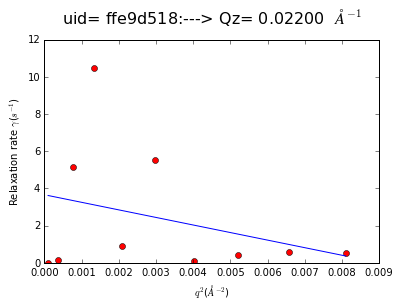

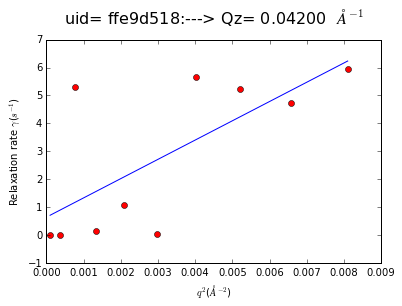

In [128]:
for qz_ind in range(num_qz): 
    fig,ax = plt.subplots()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05)
    ax.plot(qr_center**2, rate[qz_ind], 'ro', ls='')
    ax.plot(qr_center**2,  gmfit[qz_ind](qr_center**2),  ls='-')
    ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
    ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
plt.show()

## Removing bad images 

In [129]:
good_start = 4000
good_end = 4100



imgs_ =imgs[good_start: good_end-1]
imgsr = Reverse_Coordinate(imgs_, mask) 

In [132]:
import skbeam.core.mask as mask

bad_img_list = [2, 30, 206, 300, 405]

new_imgs = mask.bad_to_nan_gen(imgsr, bad_img_list)

In [133]:
num_lev = 12  # number of levels
num_buf = 8  # number of buffers


In [134]:
g2_n, lag_steps_n = corr.multi_tau_auto_corr(num_lev, num_buf,
                                         box_maskr, new_imgs)

In [136]:
lags_n = lag_steps_n * timeperframe

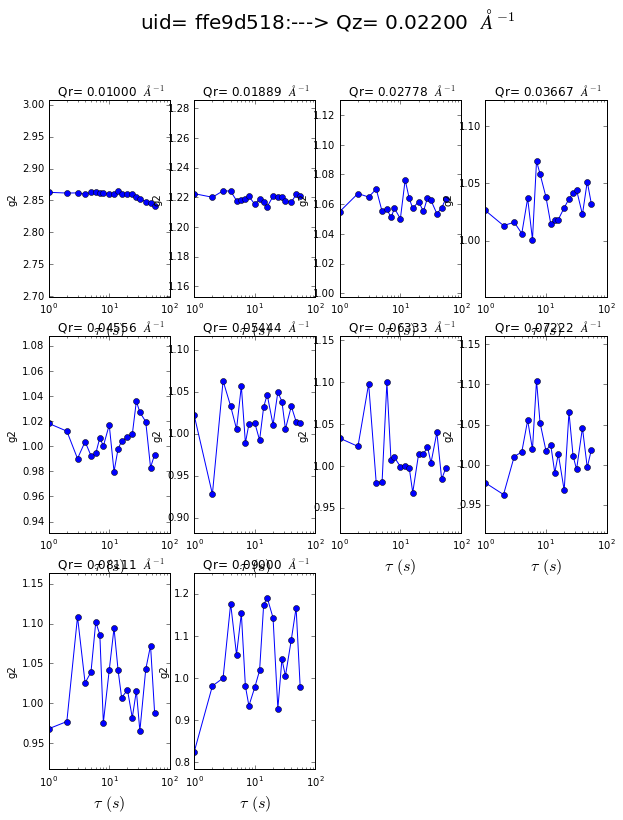

In [ ]:
vmin = 1.1
vmax=  1.15

for qz_ind in range(num_qz):
    fig = plt.figure(figsize=(10, 12))
    #fig = plt.figure()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=20, y =1.1) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    for sn in range(num_qr):
        ax = fig.add_subplot(sx,sy,sn+1 )
        ax.set_ylabel("g2") 
        ax.set_xlabel(r"$\tau $ $(s)$", fontsize=16) 
               
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:
            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        ax.set_title( title  )
            
            
        y=g2_n[:, sn + qz_ind * num_qr]
        ax.semilogx(lags_n, y, '-o', markersize=6) 
        ax.set_ylim([min(y)*.95, max(y[1:])*1.05 ])
        #ax.set_ylim( vmin, vmax)
        
    plt.show()
    fig.tight_layout()  
